In [1]:
import warnings
warnings.simplefilter('ignore')

https://github.com/albermax/innvestigate

In [2]:
import keras

Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.applications import Xception
from keras import models, layers
import keras.backend

import innvestigate
import innvestigate.utils as iutils

In [4]:
X_test=np.load("imagens_teste.npy")
y_test=np.load("labels_teste.npy")
X_train=np.load("imagens_treino.npy")
y_train=np.load("labels_treino.npy")

In [5]:
from keras.applications import VGG16
xc = VGG16(weights='imagenet',

                  include_top=False,

                  input_shape=(64, 64, 3))


In [6]:
xc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [7]:
from keras import Model
lname = "block5_pool"
last_vgg_layer = xc.get_layer(lname)


x = Flatten()(last_vgg_layer.get_output_at(0))
x = Dense(1024, activation='relu')(x)
x=Dropout(0.5)(x)
x = Dense(18, activation='softmax')(x)

model = Model(inputs=xc.inputs, outputs=x)

In [8]:
model_vgg = models.Sequential()

model_vgg.add(xc)

model_vgg.add(layers.Flatten())

model_vgg.add(layers.Dense(1024, activation='relu'))

model_vgg.add(layers.Dropout(0.5))

model_vgg.add(layers.Dense(18, activation='softmax'))

In [9]:
model_vgg.load_weights("modelo_vgg16simpson.h5")

In [10]:
weights=model_vgg.get_weights()

In [11]:
last_weights=model_vgg.layers[4].get_weights()
ante_weights=model_vgg.layers[2].get_weights()

In [14]:
model.layers[22].set_weights(last_weights) 
model.layers[20].set_weights(ante_weights) 

In [15]:
len(model.layers)

23

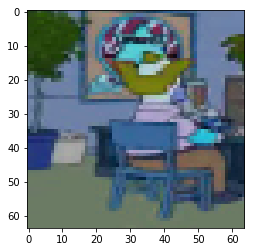

In [195]:
imgplot = plt.imshow(X_test[467])

In [196]:
images=[(X_test[120],y_test[120]),(X_test[534],y_test[534]),(X_test[448],y_test[448]),(X_test[430],y_test[430]),(X_test[327],y_test[327]),
       (X_test[786],y_test[786]),(X_test[221],y_test[221]),(X_test[835],y_test[835]),(X_test[728],y_test[728]),(X_test[561],y_test[561]),(X_test[6],y_test[6])]


In [197]:
def plot_image_grid(grid,
                    row_labels_left,
                    row_labels_right,
                    col_labels,
                    file_name=None,
                    figsize=None,
                    dpi=224):
    n_rows = len(grid)
    n_cols = len(grid[0])
    if figsize is None:
        figsize = (n_cols, n_rows+1)

    plt.clf()
    plt.rc("font", family="sans-serif")

    plt.figure(figsize=figsize)
    for r in range(n_rows):
        for c in range(n_cols):
            ax = plt.subplot2grid(shape=[n_rows+1, n_cols], loc=[r+1, c])
            # TODO controlled color mapping wrt all grid entries,
            # or individually. make input param
            if grid[r][c] is not None:
                ax.imshow(grid[r][c], interpolation='none')
            else:
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # column labels
            if not r:
                if col_labels != []:
                    ax.set_title(col_labels[c],
                                 rotation=22.5,
                                 horizontalalignment='left',
                                 verticalalignment='bottom')

            # row labels
            if not c:
                if row_labels_left != []:
                    txt_left = [l+'\n' for l in row_labels_left[r]]
                    ax.set_ylabel(
                        ''.join(txt_left),
                        rotation=0,
                        verticalalignment='center',
                        horizontalalignment='right',
                    )

            if c == n_cols-1:
                if row_labels_right != []:
                    txt_right = [l+'\n' for l in row_labels_right[r]]
                    ax2 = ax.twinx()
                    ax2.set_xticks([])
                    ax2.set_yticks([])
                    ax2.set_ylabel(
                        ''.join(txt_right),
                        rotation=0,
                        verticalalignment='center',
                        horizontalalignment='left'
                    )

    if file_name is None:
        plt.show()
    else:
        print('Saving figure to {}'.format(file_name))
        plt.savefig(file_name, orientation='landscape', dpi=dpi)

In [198]:
# Methods we use and some properties.
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Show input.
    ("input",                 {},                         "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},          "Gradient"),
    


    # Signal
    ("deconvnet",             {},                        "Deconvnet"),
    ("lrp.sequential_preset_a_flat",{"epsilon": 1},          "LRP-PresetAFlat"),

]

In [199]:

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_sm, # model without softmax output
                                                **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

In [200]:
analysis = np.zeros([len(images), len(analyzers)]+[64,64]+[3])
text = []
map_characters = {0: 'abraham', 1: 'apu', 2: 'bart', 
        3: 'burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna', 
        7: 'homer', 8: 'kent', 9: 'krusty', 10: 'lisa', 
        11: 'marge', 12: 'milhouse', 13: 'moe', 
        14: 'ned', 15: 'nelson', 16: 'skinner', 17: 'sideshow_bob'}
for i, (x, y) in enumerate(images):
    # Add batch axis.
    x_pp = x[None, :, :, :]
    #x_pp = imgnetutils.preprocess(x, net)

    # Predict final activations, probabilites, and label.
    presm = model_wo_sm.predict_on_batch(x_pp)[0]
    prob = model.predict_on_batch(x_pp)[0]
    y_hat = prob.argmax()
    y=y.argmax()
    # Save prediction info:
    text.append(("%s" % map_characters[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % map_characters[y_hat] # predicted label
                ))
    
    for aidx, analyzer in enumerate(analyzers):
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            a = [x]
        elif analyzer:
            # Analyze.
            a = analyzer.analyze(x_pp)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            #a = imgnetutils.postprocess(a, color_conversion, channels_first)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            #a = methods[aidx][2](a)
        else:
            a = np.zeros_like(image)
        # Store the analysis.
        analysis[i, aidx] = (a[0]-a[0].min())/(a[0].max()-a[0].min())

In [201]:
analysis.shape

(11, 4, 64, 64, 3)

<Figure size 432x288 with 0 Axes>

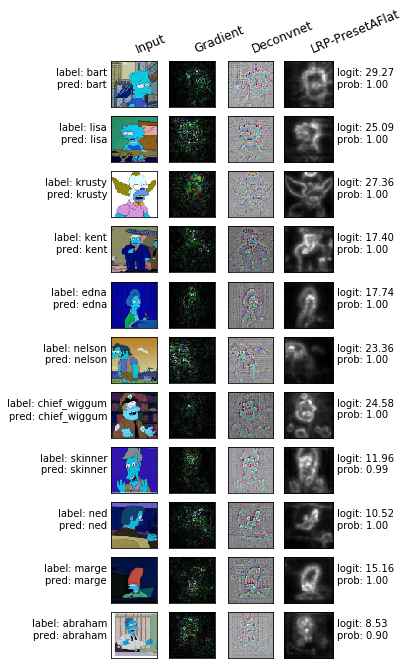

In [202]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[2]) for method in methods]

# Plot the analysis.
plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("plot_file_name", None))